# Machine Learning - ds2 Example (Distortion/Interaction DFT ML Predictions)

This is an example notebook that will take the user through replicating the results from the data found in the paper title *Distortion/Interaction Analysis via Machine Learning*.

Data is loaded in before a train test split is performed and an SVR model is evaluated using pre-determined, loaded in hyperparameters. Finally, a scatter graph is generated to replicate the results shown within the paper (Figures 5 and 6).

This is an example of how to replicate the results from the paper, however changing of the random seed other than those highlighted below will result in differences in performance. This notebook is a simplified workflow as an easy way to check performance. For full analysis, the recommendation would be that the user would perform their own hyperparameter tuning using the provided code within this repo.


### Imports

In [1]:
import sys
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.svm import SVR
from tensorflow import random
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

### Set Random Seed

To ensure reproducability, the random seed is set as 14. Within this work, multiple random seeds were used. Changing this value in the cell below to any of the other random seeds will reproduce those results instead. 

The random seeds used within the work are as follows:

> 23, 22, 14, 1, 2

14 was chosen for this example because this is the random seed used to generate Figures 5 and 6 in the paper.

In [2]:
# Set Random Seed.
rs = 14
seed(rs)
random.set_seed(rs)
tf.keras.utils.set_random_seed(rs)

### Load data

Two files are loaded in that are copied in this example directory.

| File | Description | 
| --- | --- | 
| manual_da_endo.pkl | Features and targets for ds2. |
| hps.pkl | The tuned hyperparameters for every model tested with ds2. |

In [3]:
# Load Data.
dataset = pd.read_pickle('manual_da_endo.pkl')
hps = pd.read_pickle('hps.pkl')

### Functions

Various functions that are pulled from the ML analysis to recreate this example. Each function has a description of use and arguments.

In [4]:
def _perform_train_test_split(X, y, rs):
    '''
    Function to run the train test split. 
    80:10:10 train:validation:test

    Arguments:
    X (DataFrame): A DataFrame containing the X values.
    y (DataFrame): A DataFrame containing the y values.
    rs (Integer): The random seed chosen for this run.

    Returns:
    split_dict (Dictionary): A dictionary containing DataFrames of all the different train:validation:test splits.
    '''
    # Perform the train test splits and store in split_dict.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=rs)
    split_dict = {'X_train': X_train, 'X_val':X_val, 'X_test':X_test,
                  'y_train': y_train, 'y_val':y_val, 'y_test':y_test}
    return split_dict

In [5]:
def _get_dft_features(df):
    '''
    Function to get any feature that is DFT derived and store column names in list.
    
    Arguments:
    df (DataFrame): A DataFrame of features.

    Returns:
    X (DataFrame): A DataFrame containing the X data (features).
    y (DataFrame): A DataFrame containing the y data (target).
    '''
    remove_targets = []
    for col in df:
        if '_dft' in col:
            remove_targets.append(col)
    y = df[remove_targets]
    X = df.drop(columns=remove_targets)
    return X, y

In [6]:
def _standardise_data(split_dict):
    '''
    Function to standardise the data - performed for both instances with only X and, X and y.
    Using standard scaler in sklearn to perform this.

    Arguments:
    split_dict (Dictionary): A dictionary containing DataFrames of all the different train:validation:test splits.

    Returns:
    data_dict (Dictionary): A dictionary containing the standardised data and scalers all stored in one place.
    '''
    ### Standardise only X
    sc_X = StandardScaler()
    s_train = pd.DataFrame(sc_X.fit_transform(split_dict['X_train']),
                            columns=split_dict['X_train'].columns,
                            index=split_dict['X_train'].index)
    # Perform same transformation to the X test and Validation Sets
    s_test = pd.DataFrame(sc_X.transform(split_dict['X_test']),
                            columns=split_dict['X_test'].columns,
                            index=split_dict['X_test'].index)
    s_val = pd.DataFrame(sc_X.transform(split_dict['X_val']),
                            columns=split_dict['X_val'].columns,
                            index=split_dict['X_val'].index)
    only_X = {'X_train': s_train, 'X_val':s_val, 'X_test':s_test,
            'y_train': split_dict['y_train'], 'y_val':split_dict['y_val'], 'y_test':split_dict['y_test']}
        
    ### Standardise  y
    scaler_dict = {}
    scaled_ys = {}
    for target in split_dict['y_train'].keys():
        sc_y = StandardScaler()
        ys_train = pd.DataFrame(sc_y.fit_transform(pd.DataFrame(split_dict['y_train'][target])),
                                columns=pd.DataFrame(split_dict['y_train'][target]).columns,
                                index=pd.DataFrame(split_dict['y_train'][target]).index)
            
        ys_test = pd.DataFrame(sc_y.transform(pd.DataFrame(split_dict['y_test'][target])),
                                columns=pd.DataFrame(split_dict['y_test'][target]).columns,
                                index=pd.DataFrame(split_dict['y_test'][target]).index)
            
        ys_val = pd.DataFrame(sc_y.transform(pd.DataFrame(split_dict['y_val'][target])),
                                columns=pd.DataFrame(split_dict['y_val'][target]).columns,
                                index=pd.DataFrame(split_dict['y_val'][target]).index)
        scaled_ys[target] = {'train':ys_train, 'test':ys_test, 'val':ys_val}
        scaler_dict[target] = sc_y

    # Build DataFrames and concatenate the data - store in data_dict.
    all_ys_train, all_ys_test, all_ys_val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()     
    for target in scaled_ys.keys():
        all_ys_train = pd.concat([all_ys_train, scaled_ys[target]['train']], axis=1)
        all_ys_test = pd.concat([all_ys_test, scaled_ys[target]['test']], axis=1)
        all_ys_val = pd.concat([all_ys_val, scaled_ys[target]['val']], axis=1)
    both_X_y = {'X_train':s_train, 'X_val':s_val, 'X_test':s_test,
                'y_train':all_ys_train, 'y_val':all_ys_val, 'y_test':all_ys_test}
    data_dict = {'just_X': only_X, 'both_X_y':both_X_y, 'X_scaler':sc_X, 'y_scaler':scaler_dict}
    return data_dict

### Perform ML Analysis

The function _runner will generate the metrics for all targets with the SVR models. 

The function _plot will  generate a scatter graph of the results for each target.

In [7]:
def _runner(dataset, hps, rs):
    '''
    Function to run the ML analysis.

    This function utilises other fuctions to perform the splits of the data and partitions it before 
    then deciding which models to run and running those. This currently only works for single task models.

    Arguments:
    dataset (DataFrame): A DataFrame containing the features and targets.
    hps (Dictionary): A dictionary containing the hyperprameters for the SVR models trained on ds2.
    rs (Integer): The random seed chosen for this run.

    Returns:
    results (Dictionary): A dictionary containing the results for SVR models on ds2.

    '''            
    # Load data and extract targets.
    X, y = _get_dft_features(dataset)
    # Perform Train/Test/Validation splits and standardise.
    splits_dict = _perform_train_test_split(X, y, rs)
    data_dict = _standardise_data(splits_dict)
    # Create list of models to test.
    svr_models = [model for model in hps.keys() if 'svr' in model]
    svr_models.remove('svr_sum_distortion_energies_dft')

    # Loop through each target.
    results = {}
    for model in svr_models:
        # Pull out the best hyperparameters.
        m = SVR(**hps[model]['b_hps'])
        target = model.split('svr_')[-1]
        # Fit the model and make predictions.
        fit_m = m.fit(data_dict['just_X']['X_train'], data_dict['just_X']['y_train'][target])
        test_pred = fit_m.predict(data_dict['just_X']['X_test'])
        results[target] = {'test_mae':np.round(mean_absolute_error(test_pred, data_dict['just_X']['y_test'][target]), 4),
                           'test_pred_values': test_pred,
                           'test_true_values': data_dict['just_X']['y_test'][target]}
    return results

In [8]:
def _plot(results, target):
    '''
    Function to generate a scatter graph for the results.

    The list of potential targets is as follows:
    ['e_barrier_dft', 'q_barrier_dft', 'interaction_energies_dft', 'distortion_energy_di_dft', 'distortion_energy_dp_dft']

    Arguments
    results (Dictionary): A dictionary containing the results for SVR models on ds2.
    target (String): The chosen target to visualise this random seeds results for.
    '''
    # Store colours and titles in a dictionary.
    inf = {
        'e_barrier_dft':['slateblue', 'indigo', r"$\Delta$E"],
        'q_barrier_dft':['cornflowerblue', 'navy', r"$\Delta$G"],
        'interaction_energies_dft':['forestgreen', 'darkgreen', 'Interaction Energy'],
        'distortion_energy_di_dft':['lightcoral', 'maroon', 'Diene Distortion Energy'],
        'distortion_energy_dp_dft':['lightcoral', 'maroon', 'Dienophile Distortion Energy']
    }
    plt.rcParams["font.family"] = "Century"
    if target == 'interaction_energies_dft':
        plt.scatter(results[target]['test_pred_values']*-1, results[target]['test_true_values']*-1, color=inf[target][0], edgecolor=inf[target][1], s=50, linewidth=1.5)
        plt.xlim(-max(results[target]['test_pred_values'])-1, -min(results[target]['test_pred_values'])+1)
        plt.ylim(-max(results[target]['test_true_values'])-1, -min(results[target]['test_true_values'])+1)
    else:
        plt.scatter(results[target]['test_pred_values'], results[target]['test_true_values'], color=inf[target][0], edgecolor=inf[target][1], s=50, linewidth=1.5)
        plt.xlim(min(results[target]['test_pred_values'])-1, max(results[target]['test_pred_values'])+1)
        plt.ylim(min(results[target]['test_true_values'])-1, max(results[target]['test_true_values'])+1)
    plt.plot([100, -100], [100, -100], linestyle='--', color='black', linewidth=2)
    plt.fill_between([100, -100], [100+1, -100+1], [100-1, -100-1], color='grey', edgecolor='white', alpha=0.5, label='_nolegend_', zorder=0)
    props = {'weight':'bold', 'size':14} 
    plt.legend([f"Test MAE: {np.round(results[target]['test_mae'], 2)} kcal/mol\nRandom Seed: {rs}"], markerscale=0, handletextpad=0, markerfirst=False, frameon=False, prop=props)
    plt.title(inf[target][2], fontsize=18)
    plt.xlabel('Predicted DFT Energy / kcal mol$^{-1}$', fontsize=15)
    plt.ylabel('True DFT Energy / kcal mol$^{-1}$', fontsize=15)
    plt.show()

In [9]:
# Generate results.
results = _runner(dataset, hps, rs)

# Print results.
print('{:30s} {:30s}'.format('Target', 'Test MAE'))
print('{:30s} {:30s}'.format('------', '------'))
print(*[f'{i:30s} {np.round(results[i]['test_mae'], 2)} kcal/mol' for i in results.keys()], sep='\n')

Target                         Test MAE                      
------                         ------                        
e_barrier_dft                  0.51 kcal/mol
q_barrier_dft                  0.48 kcal/mol
interaction_energies_dft       0.41 kcal/mol
distortion_energy_di_dft       0.25 kcal/mol
distortion_energy_dp_dft       0.29 kcal/mol


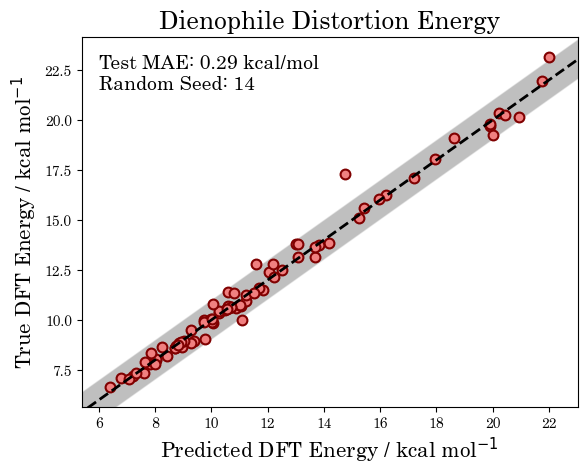

In [10]:
# Plot results - see function for different targets.
_plot(results, 'distortion_energy_dp_dft')